In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

%matplotlib notebook

In [39]:
def evolve3D(grid, b, num_steps=1):
    L = grid.shape[0]
    current = np.zeros((L, L, L), dtype=int)
    scores = np.zeros((L, L, L), dtype=float)
    for step in range(num_steps):
        current = grid.copy()
        scores = np.zeros((L, L, L), dtype=float)
        for x in range(L):
            for y in range(L):
                for z in range(L):
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            for k in range(-1, 2):
                                ix = (x + i) % L
                                jy = (y + j) % L
                                kz = (z + k) % L
                                scores[x, y, z] += (1 - grid[ix, jy, kz])
                    if grid[x, y, z] == 1:
                        scores[x, y, z] *= b
        for x in range(L):
            for y in range(L):
                for z in range(L):
                    bestX = x
                    bestY = y
                    bestZ = z
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            for k in range(-1, 2):
                                ix = (x + i) % L
                                jy = (y + j) % L
                                kz = (z + k) % L
                                if (scores[bestX, bestY, bestZ] < scores[ix, jy, kz]):
                                    bestX = ix
                                    bestY = jy
                                    bestZ = kz
                    grid[x, y, z] = current[bestX, bestY, bestZ]
    return grid

In [3]:
def show_grid(grid, d3 = False, slises=False):
    global L
    if d3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        # ax.grid(False)
        # ax.set_axis_off()
        colors = {0:'b', 1:'r'}
        for i in range(L):
            for j in range(L):
                for k in range(L):
                    ax.scatter(i, j, k, c=colors[grid[i,j,k]], s=5) # s=np.sqrt(((i+1)**2 + (k + 1)**2 + (L-j)**2)/3) show depth through size

        plt.show()

    '''
    supporting lines
    '''            
    # for i in range(L):
    #     for j in range(L):
    #         ax.plot([i,i], [j,j], [0, L - 1], c='0.5', linewidth=0.5)
    #         ax.plot([0, L - 1], [j,j], [i,i], c='0.5', linewidth=0.5)
    #         ax.plot([j,j], [0, L - 1], [i,i], c='0.5', linewidth=0.5)
    if slises:
        rows = L
        columns = 3
        fig = plt.figure()
        for i in range(L):
            fig.add_subplot(rows, columns, i*3 + 1)
            plt.imshow(grid[i,:,:], cmap=plt.get_cmap('Paired'))
            fig.add_subplot(rows, columns, i*3 + 2)
            plt.imshow(grid[:,i,:], cmap=plt.get_cmap('Paired'))
            fig.add_subplot(rows, columns, i*3 + 3)
            plt.imshow(grid[:,:,i], cmap=plt.get_cmap('Paired'))
        plt.show()


    rows = 1
    columns = 3
    fig = plt.figure()
    Px = np.zeros((L, L), dtype=int)
    Py = np.zeros((L, L), dtype=int)
    Pz = np.zeros((L, L), dtype=int)
    for i in range(L):
        Px += grid[i, :, :]
        Py += grid[:, i, :]
        Pz += grid[:, :, i]
    Px = Px / L
    Py = Py / L
    Pz = Pz / L
    fig.add_subplot(rows, columns, 1)
    plt.imshow(Px)
    fig.add_subplot(rows, columns, 2)
    plt.imshow(Py)
    fig.add_subplot(rows, columns, 3)
    plt.imshow(Pz)
    plt.show()

In [4]:
%load_ext cython

In [87]:
%%cython -a
import numpy as np
import cython
cimport numpy as np
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def evolve3D_c(short[:, :, :] grid, double b, int num_steps=1):
    
    cdef int x, y, z, L, i, j, k, ix, jy, kz, step, bestX, bestY, bestZ
    
    L = grid.shape[0]
    cdef double[:, :, :] scores = np.zeros((L, L, L), dtype=float)
    
    cdef double[:, :, :] _zeros = np.zeros((L, L, L), dtype=float)
    cdef short[:, :, :] current = grid.copy()
    
    for step in range(num_steps):
        current = grid.copy()
        scores[...] = _zeros
        
        for x in range(L):
            for y in range(L):
                for z in range(L):
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            for k in range(-1, 2):
                                ix = (x + i + L) % L
                                jy = (y + j + L) % L
                                kz = (z + k + L) % L
                                scores[x, y, z] += (1 - grid[ix, jy, kz])
                                
                    if grid[x, y, z] == 1:
                        scores[x, y, z] *= b
                    
                        
        for x in range(L):
            for y in range(L):
                for z in range(L):
                    bestX = x
                    bestY = y
                    bestZ = z
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            for k in range(-1, 2):
                                ix = (x + i + L) % L
                                jy = (y + j + L) % L
                                kz = (z + k + L) % L
                                if (scores[bestX, bestY, bestZ] < scores[ix, jy, kz]):
                                    bestX = ix
                                    bestY = jy
                                    bestZ = kz
                                    
                    grid[x, y, z] = current[bestX, bestY, bestZ]
                    
    return grid

In [88]:
L = 60
b = 1.3
C_prob = 0.1

grid = np.random.choice(2, (L, L, L), p=[C_prob, 1 - C_prob])

# grid = np.zeros((L, L, L), dtype=int)
# grid[L//2, L//2, L//2] = 1

grid = grid.astype('int16')
grid =  np.array(evolve3D_c(grid, b, num_steps=100))

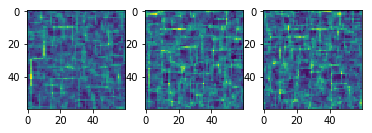

In [89]:
show_grid(grid)

In [90]:
%timeit evolve3D_c(grid, b, num_steps=1)

136 ms ± 6.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [91]:
%timeit evolve3D_c(grid, b, num_steps=10)

1.28 s ± 59.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit evolve3D(grid, b, num_steps=1)

57.7 s ± 1.42 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
B = []
for i in range(28):
    for j in range(1, 28):
        if i/j > 1 and i / j < 2:
            B.append(i/j)
B.sort()

In [56]:
Fc = np.zeros((len(B)), dtype=float)
L = 60
c_prob = 0.5
grid = np.random.choice(2, (L, L, L), p=[C_prob, 1 - C_prob])
grid = grid.astype('int16')
for i in range(0, len(B), 10):
    b = B[i]
    grid = np.random.choice(2, (L, L, L), p=[C_prob, 1 - C_prob])
    grid = grid.astype('int16')
    grid = np.array(evolve3D_c(grid, b, num_steps=50))
    print('b =',b)
    for j in range(5):
        grid = np.array(evolve3D_c(grid, b, num_steps=10))
        Fc[i] += (L**3 - grid.sum())/(L**3)
    Fc[i] = Fc[i]/5
    print('Fc =', Fc[i])

b = 1.0384615384615385
Fc = 0.9839444444444444
b = 1.0625
Fc = 0.9828148148148148
b = 1.0952380952380953
Fc = 0.9481064814814815
b = 1.1304347826086956
Fc = 0.930825925925926
b = 1.1666666666666667
Fc = 0.950011111111111
b = 1.2
Fc = 0.9486009259259258
b = 1.25
Fc = 0.9384675925925926
b = 1.2857142857142858
Fc = 0.7977222222222222
b = 1.3333333333333333
Fc = 0.9833333333333332
b = 1.375
Fc = 0.9508287037037035
b = 1.4285714285714286
Fc = 0.0
b = 1.5
Fc = 0.0
b = 1.5454545454545454
Fc = 0.0
b = 1.6153846153846154
Fc = 0.0
b = 1.6875
Fc = 0.0
b = 1.7692307692307692
Fc = 0.0
b = 1.8571428571428572
Fc = 0.0


In [84]:
%%cython -a

import numpy as np

import cython

@cython.cdivision(True)
@cython.boundscheck(False)
def evolve2_1(long[:, ::1] field, double b, int num_steps=1):
    
    cdef int x, y, L, i, j, ix, jy, step
    
    L = field.shape[0]
    cdef double[:, ::1] scores = np.zeros((L, L), dtype=float)
    
    cdef double[:, ::1] _zeros = np.zeros((L, L), dtype=float)
    cdef long[:, ::1] current = field.copy()
    
    for step in range(num_steps):
        current = field.copy()
        scores[...] = _zeros
        
        for x in range(L):
            for y in range(L):
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        ix = (x + i) % L
                        jy = (y + j) % L
                        scores[x, y] += (1 - field[ix, jy])
                        
                if field[x, y] == 1:
                    scores[x, y] *= b
        
        for x in range(L):
            for y in range(L):
                bestX = x
                bestY = y
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        ix = (x + i) % L
                        jy = (y + j) % L
                        if (scores[bestX, bestY] < scores[ix, jy]):
                            bestX = ix
                            bestY = jy
                
                field[x, y] = current[bestX, bestY]
    return field

In [85]:
L = 60
b = 1.3
C_prob = 0.1
# grid = np.zeros((L, L, L), dtype='int64')

grid = np.random.choice(2, (L, L), p=[C_prob, 1 - C_prob])
grid = grid.astype('int32')
evolve2_1(grid, 1.8, 1)

<MemoryView of 'ndarray' at 0x1e011829a38>

# Tabulate the neighbors

In [36]:
NUM_NEIGHB = 27

def get_site(coord, L):
    """Get the site index from the 3-vector of coordinates."""
    # XXX: 3D hardcoded, can do N-D
    return coord[0] + coord[1]*L + coord[2]*L*L


def get_coord(site, L):
    """Get the 3-vector of coordinates from the site index."""
    # XXX: 3D hardcoded, can do N-D
    z = site // (L*L)
    xy = site % (L*L)
    y = xy // L
    x = xy % L
    return [x, y, z]
    

def get_neighbors(site, L):
    neighb = []
    x, y, z = get_coord(site, L)
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            for k in [-1, 0, 1]:
                x1 = (x + i) % L
                y1 = (y + j) % L
                z1 = (z + k) % L
                neighb.append(get_site([x1, y1, z1], L))
    return neighb

    
def tabulate_neighbors(L):
    """Tabulate the root-2 neighbors on the 3D cubic lattice with PBC."""
    Nsite = L*L*L
    neighb = np.empty((Nsite, NUM_NEIGHB), dtype=int)
    for site in range(Nsite):
        neighb[site, :] = get_neighbors(site, L)
    return neighb

In [32]:
# Test conversion sites <--> coords

from numpy.testing import assert_equal

L = 3
for site in range(L*L*L):
    xyz = get_coord(site, L)
    site1 = get_site(xyz, L)
    #print(site, xyz, site1)
    assert_equal(site, site1)

# TODO: test neighbors (distance w/PBC?)

In [30]:
for nghb in get_neighbors(13, L):
    print(nghb, get_coord(nghb, L), end=" -- ")

0 [0, 0, 0] -- 9 [0, 0, 1] -- 18 [0, 0, 2] -- 3 [0, 1, 0] -- 12 [0, 1, 1] -- 21 [0, 1, 2] -- 6 [0, 2, 0] -- 15 [0, 2, 1] -- 24 [0, 2, 2] -- 1 [1, 0, 0] -- 10 [1, 0, 1] -- 19 [1, 0, 2] -- 4 [1, 1, 0] -- 13 [1, 1, 1] -- 22 [1, 1, 2] -- 7 [1, 2, 0] -- 16 [1, 2, 1] -- 25 [1, 2, 2] -- 2 [2, 0, 0] -- 11 [2, 0, 1] -- 20 [2, 0, 2] -- 5 [2, 1, 0] -- 14 [2, 1, 1] -- 23 [2, 1, 2] -- 8 [2, 2, 0] -- 17 [2, 2, 1] -- 26 [2, 2, 2] -- 

In [50]:
L = 10

neighbors = tabulate_neighbors(L)


def evolve3D_2(grid, b, num_steps=1):
    
    assert grid.shape[0] == L
    
    current = np.zeros((L, L, L), dtype=int)
    scores = np.zeros((L, L, L), dtype=float)
    for step in range(num_steps):
        current = grid.copy()
        scores = np.zeros((L, L, L), dtype=float)
        for x in range(L):
            for y in range(L):
                for z in range(L):
                    
                    # TODO: 1. replace loops over i,j,k w/ a single loop over the neighbors
                    #       2. replace 3D `grid` array with 1D array, and replace loops
                    #          over x,y,z w/ a single loop over the sites
                    #       3. check that the dynamics is identical
                    #       4. allow for L(1) != L(2) != L(3), take L(3) = 1 and check agreement with
                    #          2D calculations.
                    #       5. cythonize
                    site = get_site([x, y, z], L)
                    for site1 in neighbors[site]:
                        ix, iy, iz = get_coord(site1, L)
                        scores[x, y, z] += 1 - grid[ix, iy, iz]
                    
                    #for i in range(-1, 2):
                    #    for j in range(-1, 2):
                    #        for k in range(-1, 2):
                    #            ix = (x + i) % L
                    #            jy = (y + j) % L
                    #            kz = (z + k) % L
                    #            scores[x, y, z] += (1 - grid[ix, jy, kz])
                    if grid[x, y, z] == 1:
                        scores[x, y, z] *= b
        for x in range(L):
            for y in range(L):
                for z in range(L):
                    bestX = x
                    bestY = y
                    bestZ = z
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            for k in range(-1, 2):
                                ix = (x + i) % L
                                jy = (y + j) % L
                                kz = (z + k) % L
                                if (scores[bestX, bestY, bestZ] < scores[ix, jy, kz]):
                                    bestX = ix
                                    bestY = jy
                                    bestZ = kz
                    grid[x, y, z] = current[bestX, bestY, bestZ]
    return grid

In [65]:
rndm = np.random.RandomState(12345)

field = (rndm.uniform(size=(L, L, L)) > 0.5).astype(int)
field2 = field.copy()

orig = field.copy()

ff = evolve3D(field, 1.3, num_steps=100)
ff2 = evolve3D_2(field2, 8.3, num_steps=10)
assert_equal(ff, ff2)

In [62]:
(field == ff).all()

True

In [63]:
(field2 == ff).all()

False